# Symptom Analyzer: Disease Prediction System
An interactive ML-based system for predicting diseases from symptoms using multiple machine learning approaches.

This notebook demonstrates:
1. Loading and preprocessing symptom data
2. Training multiple ML models (Naive Bayes, Random Forest, Deep Learning)
3. Comparing model performance visually
4. Making predictions with an ensemble approach
5. Visualizing prediction confidence and importance

## 1. Setup and Imports
First, we'll import all necessary libraries and configure our environment.

In [38]:
# Import standard libraries
import pandas as pd
import numpy as np
import os
import re
import warnings
import joblib
from datetime import datetime

# Suppress warnings and TensorFlow logs
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Import ML libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Try importing deep learning libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.utils import to_categorical
    tensorflow_available = True
    print("TensorFlow available - deep learning model will be enabled")
except ImportError:
    tensorflow_available = False
    print("TensorFlow not available - deep learning model will be disabled")

# Create model and data directories if they don't exist
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

TensorFlow available - deep learning model will be enabled


## 2. Text Preprocessing
Define stopwords and text preprocessing functions to clean symptom descriptions.

In [39]:
# Define English stopwords (simplified version)
STOPWORDS = {
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through',
    'during', 'before', 'after', 'to', 'from', 'in', 'out', 'on', 'off'
}

def preprocess_text(text):
    '''Process text by removing stopwords and punctuation'''
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and replace with spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove stopwords
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in STOPWORDS]
    
    # Return processed text
    return ' '.join(filtered_tokens)

## 3. Dataset Creation and Exploration
Load or create a dataset of symptoms and corresponding diseases.

In [40]:
def load_dataset(file_path=None):
    '''Load and prepare dataset in various formats for symptom analysis'''
    # Try to use provided path or default locations
    dataset_paths = [file_path] if file_path else ['data/data.csv', 'data/dataset.csv', 'data/symptoms.csv']
    dataset_paths = [p for p in dataset_paths if p]  # Remove None values
    
    for path in dataset_paths:
        if os.path.exists(path):
            print(f"Loading dataset from {path}")
            df = pd.read_csv(path)
            
            # Handle different dataset formats:
            
            # 1. Standard format (Symptoms, Disease columns)
            if 'Symptoms' in df.columns and 'Disease' in df.columns:
                print("Using dataset with standard format (Symptoms, Disease)")
                return df
            
            # 2. Reversed standard format (Disease, Symptoms columns)
            elif 'Disease' in df.columns and any(col for col in df.columns if col != 'Disease' and 'Symptom' in col):
                print("Using dataset with reversed columns (Disease and symptoms)")
                # Find symptom columns
                symptom_cols = [col for col in df.columns if col != 'Disease' and 'Symptom' in col]
                # Combine symptoms into a single text field
                df['Symptoms'] = df[symptom_cols].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
                return df[['Symptoms', 'Disease']]
            
            # 3. Wide format (diseases as target, symptoms as binary columns)
            elif 'diseases' in df.columns or 'disease' in df.columns:
                disease_col = 'diseases' if 'diseases' in df.columns else 'disease'
                print(f"Using dataset with wide format ({disease_col} as target)")
                # Get all symptom columns (all except the disease column)
                symptom_cols = [col for col in df.columns if col != disease_col]
                
                # Sample if very large (for performance)
                if len(df) > 1000:
                    print(f"Sampling 1000 rows from {len(df)} total rows")
                    df = df.sample(n=1000, random_state=42)
                
                # Create standardized format
                rows = []
                for _, row in df.iterrows():
                    disease = row[disease_col]
                    # Either get symptoms with value 1 (binary) or non-zero/non-NaN (continuous)
                    present_symptoms = []
                    for col in symptom_cols:
                        if pd.notna(row[col]) and row[col] not in (0, '0', '', 'no', 'No', 'NO'):
                            present_symptoms.append(col)
                    
                    if present_symptoms:
                        symptoms_text = ' '.join(present_symptoms)
                        rows.append({'Symptoms': symptoms_text, 'Disease': disease})
                
                result_df = pd.DataFrame(rows)
                print(f"Created {len(result_df)} symptom-disease pairs")
                return result_df
            
            # 4. Any other format with at least two columns - guess which is symptoms/disease
            elif len(df.columns) >= 2:
                print("Using dataset with unknown format - attempting to infer structure")
                # Use first column as symptoms and second as disease (common convention)
                col1, col2 = df.columns[:2]
                df_renamed = df[[col1, col2]].copy()
                df_renamed.columns = ['Symptoms', 'Disease']
                print(f"Using '{col1}' as Symptoms and '{col2}' as Disease")
                return df_renamed
    
    # If no dataset found, create a minimal sample dataset
    print("No suitable dataset found. Creating sample dataset...")
    sample_data = {
        'Symptoms': [
            "fever headache cough runny nose", 
            "chest pain shortness of breath pain in arm sweating",
            "high fever headache stiff neck light sensitivity",
            "fatigue weight loss night sweats persistent cough",
            "abdominal pain diarrhea nausea vomiting"
        ],
        'Disease': [
            "Common Cold", 
            "Heart Attack", 
            "Meningitis", 
            "Tuberculosis", 
            "Gastroenteritis"
        ]
    }
    
    # Create a dataframe
    return pd.DataFrame(sample_data)

In [41]:
# Load dataset and preprocess
df = load_dataset()

# Add processed symptoms column 
df['Processed_Symptoms'] = df['Symptoms'].apply(preprocess_text)

# Display dataset information
print(f"\nDataset contains {len(df)} samples with {df['Disease'].nunique()} unique diseases")
print(f"Top 5 diseases: {', '.join(df['Disease'].value_counts().head().index.tolist())}")
print(f"Sample row: {df.iloc[0]['Symptoms']} → {df.iloc[0]['Disease']}")

Loading dataset from data/data.csv
Using dataset with reversed columns (Disease and symptoms)

Dataset contains 4920 samples with 41 unique diseases
Top 5 diseases: Fungal infection, Hepatitis C, Hepatitis E, Alcoholic hepatitis, Tuberculosis
Sample row: itching  skin_rash  nodal_skin_eruptions  dischromic _patches → Fungal infection


## 4. Data Visualization
Visualize the distribution of diseases in our dataset.

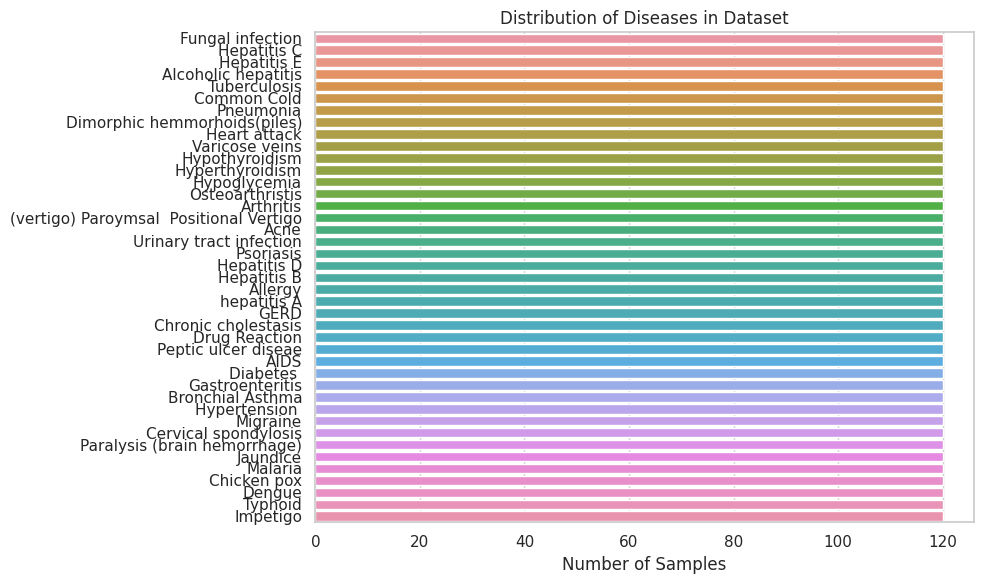

In [42]:
# Visualize disease distribution
plt.figure(figsize=(10, 6))
disease_counts = df['Disease'].value_counts()
sns.barplot(x=disease_counts.values, y=disease_counts.index)
plt.title('Distribution of Diseases in Dataset')
plt.xlabel('Number of Samples')
plt.tight_layout()
plt.show()

## 5. Feature Extraction and Data Preparation
Extract features from symptoms and prepare data for model training.

In [47]:
# Feature extraction using TF-IDF
print("Extracting features using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['Processed_Symptoms'])

# Encode disease labels
le = LabelEncoder()
y = le.fit_transform(df['Disease'])

# Count occurrences of each disease class
class_counts = pd.Series(y).value_counts()
rare_classes = class_counts[class_counts < 2].index.tolist()

if rare_classes:
    print(f"Warning: Found {len(rare_classes)} disease classes with only one sample each.")
    # Filter out samples with rare diseases to allow stratification
    mask = ~df['Disease'].isin(le.inverse_transform(rare_classes))
    print(f"Filtering out {(~mask).sum()} samples with rare diseases for model training.")
    # Filter X and y
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Get diseases we're keeping for reporting
    kept_diseases = df.loc[mask, 'Disease'].unique()
    # Create a new label encoder for the filtered data
    filtered_le = LabelEncoder()
    filtered_le.fit(kept_diseases)
    # Transform the filtered labels
    y_filtered = filtered_le.transform(df.loc[mask, 'Disease'])
    
    # Use this label encoder for further processing
    le = filtered_le
    y = y_filtered
    X = X_filtered
    
    print(f"Proceeding with {len(le.classes_)} disease classes.")

# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
print(f"Feature space dimensions: {X.shape[1]} features")

# Show top features
feature_names = vectorizer.get_feature_names_out()
print(f"\nTop 10 features (symptoms): {', '.join(feature_names[:10])}...")

Extracting features using TF-IDF...
Training on 3444 samples, testing on 1476 samples
Feature space dimensions: 100 features

Top 10 features (symptoms): abdominal_pain, abnormal_menstruation, acidity, back_pain, bladder_discomfort, blister, blood_in_sputum, bloody_stool, blurred_and_distorted_vision, breathlessness...


## 6. Model Training - Naive Bayes
Train a Multinomial Naive Bayes classifier for symptom-disease prediction.

Training Naive Bayes model...
Naive Bayes Accuracy: 0.9919


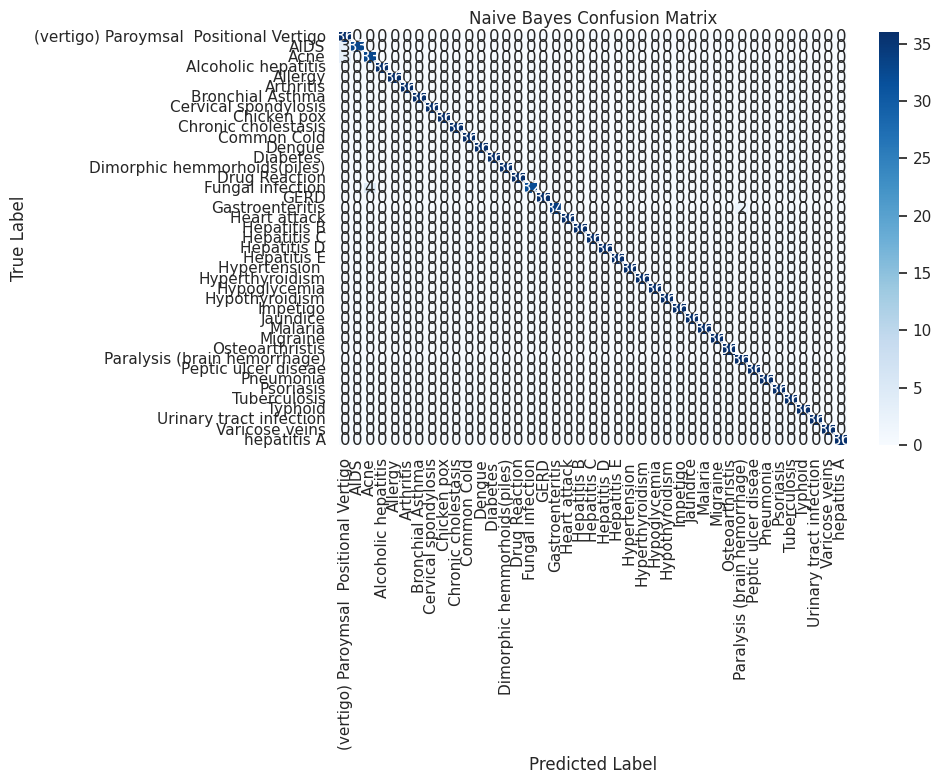


Naive Bayes Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       0.86      1.00      0.92        36
                                   AIDS       1.00      0.92      0.96        36
                                   Acne       0.89      0.92      0.90        36
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        36
                       Bronchial Asthma       1.00      1.00      1.00        36
                   Cervical spondylosis       1.00      1.00      1.00        36
                            Chicken pox       1.00      1.00      1.00        36
                    Chronic cholestasis       1.00      1.00      1.00        36
                            Common Cold       1.00      1.00      1.00  

In [48]:
print("Training Naive Bayes model...")
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)

# Evaluate Naive Bayes model
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")

# Show confusion matrix
plt.figure(figsize=(10, 8))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report - ensure we only include labels that are present in both test and predictions
unique_labels = sorted(list(set(y_test) | set(y_pred_nb)))
class_names = [le.classes_[i] for i in unique_labels]

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, labels=unique_labels, target_names=class_names))

## 7. Model Training - Random Forest
Train a Random Forest classifier for symptom-disease prediction.

Training Random Forest model...
Random Forest Accuracy: 0.9939


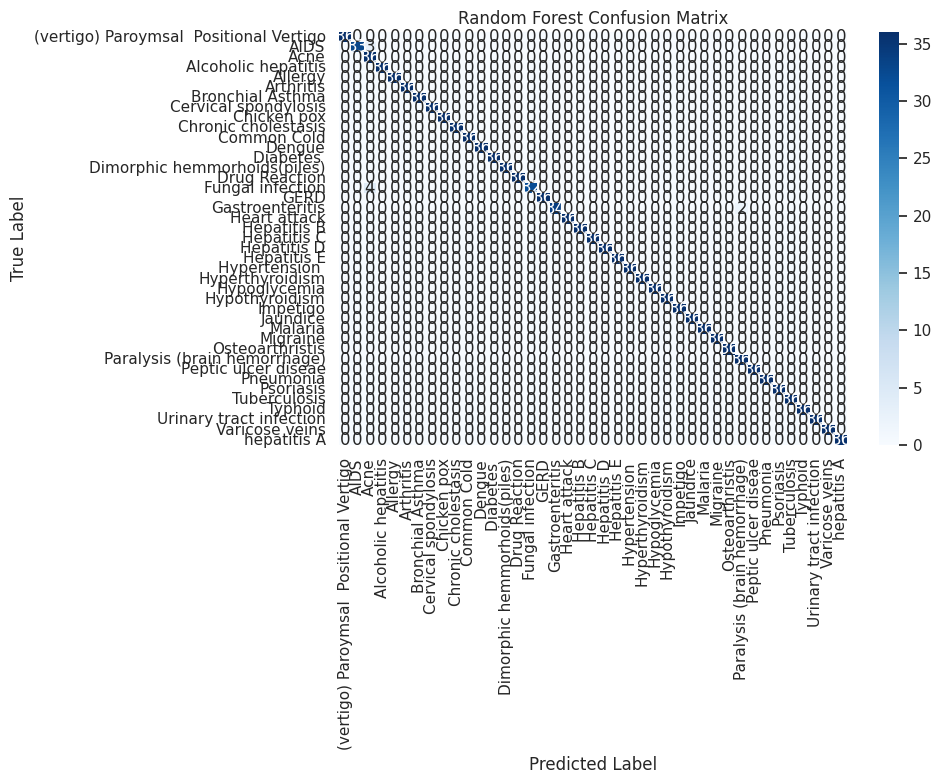


Random Forest Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        36
                                   AIDS       1.00      0.92      0.96        36
                                   Acne       0.84      1.00      0.91        36
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        36
                       Bronchial Asthma       1.00      1.00      1.00        36
                   Cervical spondylosis       1.00      1.00      1.00        36
                            Chicken pox       1.00      1.00      1.00        36
                    Chronic cholestasis       1.00      1.00      1.00        36
                            Common Cold       1.00      1.00      1.00

In [49]:
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Show confusion matrix
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
# Find unique labels present in both test and predictions
unique_labels = sorted(list(set(y_test) | set(y_pred_rf)))
class_names = [le.classes_[i] for i in unique_labels]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, labels=unique_labels, target_names=class_names))

## 8. Feature Importance Analysis
Analyze which symptoms are most important for prediction according to the Random Forest model.

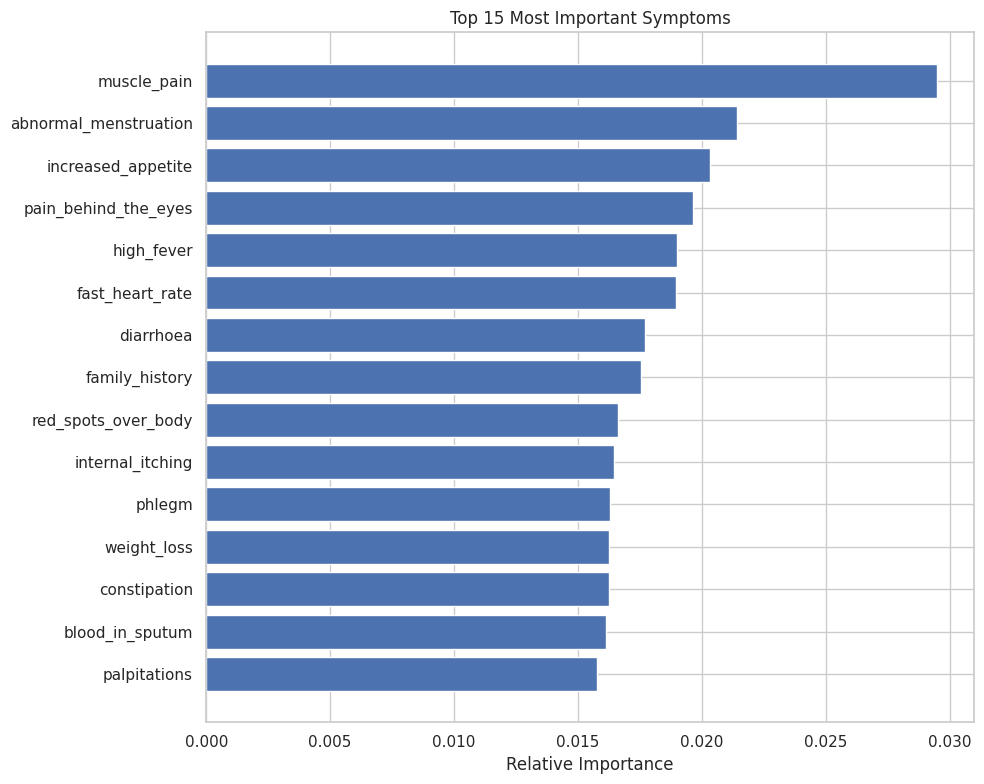

Top 10 most important symptoms for disease prediction:
  - muscle_pain: 0.0295
  - abnormal_menstruation: 0.0214
  - increased_appetite: 0.0203
  - pain_behind_the_eyes: 0.0196
  - high_fever: 0.0190
  - fast_heart_rate: 0.0189
  - diarrhoea: 0.0177
  - family_history: 0.0176
  - red_spots_over_body: 0.0166
  - internal_itching: 0.0165


In [50]:
# Analyze feature importance from Random Forest
feature_importance = rf_model.feature_importances_
indices = np.argsort(feature_importance)[-15:]
    
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), feature_importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 15 Most Important Symptoms')
plt.tight_layout()
plt.show()

# Print top 10 most important symptoms
print("Top 10 most important symptoms for disease prediction:")
for i in indices[-10:][::-1]:
    print(f"  - {feature_names[i]}: {feature_importance[i]:.4f}")

## 9. Model Training - Deep Learning
Train a neural network for symptom-disease prediction (if TensorFlow is available).

Training Deep Learning model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               12928     
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_13 (Bat  (None, 64)               256       
 chNormalization)     

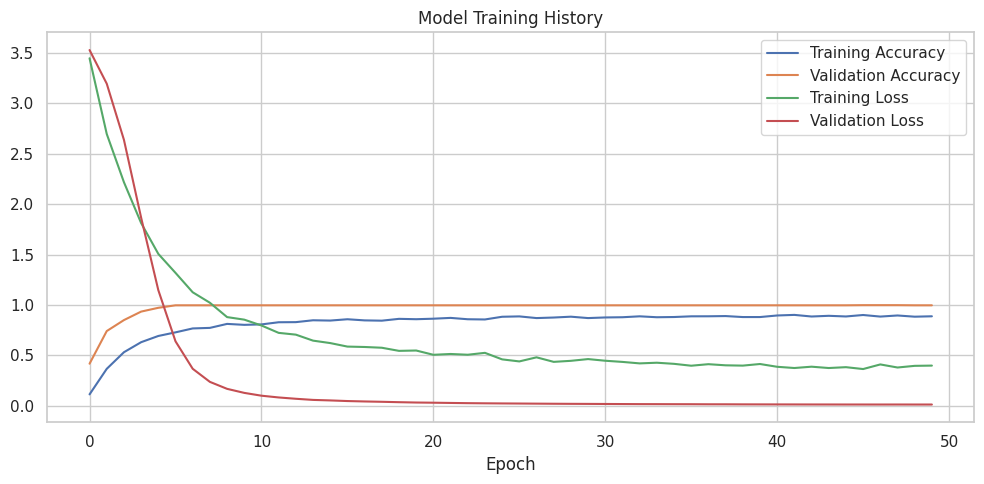


Deep Learning Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        36
                                   AIDS       1.00      0.92      0.96        36
                                   Acne       0.89      0.92      0.90        36
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        36
                              Arthritis       1.00      1.00      1.00        36
                       Bronchial Asthma       1.00      1.00      1.00        36
                   Cervical spondylosis       1.00      1.00      1.00        36
                            Chicken pox       1.00      1.00      1.00        36
                    Chronic cholestasis       1.00      1.00      1.00        36
                            Common Cold       1.00      1.00      1.00

In [52]:
# Train deep learning model if TensorFlow is available
if tensorflow_available:
    print("Training Deep Learning model...")
    
    # Prepare data for deep learning
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()
    
    num_classes = len(le.classes_)
    y_train_onehot = to_categorical(y_train, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)
    
    # Determine model size based on dataset size
    # - Use smaller network for small datasets
    # - Use larger network for larger datasets
    if X_train.shape[0] < 50:  # Very small dataset
        units = [64, 32]
        dropout_rates = [0.3, 0.2]
    else:  # Larger dataset
        units = [128, 64, 32]
        dropout_rates = [0.4, 0.4, 0.3]
    
    # Build neural network
    model_layers = []
    
    # Input layer
    model_layers.append(Dense(units[0], input_shape=(X_train_dense.shape[1],)))
    model_layers.append(tf.keras.layers.BatchNormalization())
    model_layers.append(tf.keras.layers.Activation('relu'))
    model_layers.append(Dropout(dropout_rates[0]))
    
    # Hidden layers
    for i in range(1, len(units)):
        model_layers.append(Dense(units[i]))
        model_layers.append(tf.keras.layers.BatchNormalization())
        model_layers.append(tf.keras.layers.Activation('relu'))
        model_layers.append(Dropout(dropout_rates[i]))
    
    # Output layer
    model_layers.append(Dense(num_classes, activation='softmax'))
    
    # Create model
    dl_model = Sequential(model_layers)
    
    # Use a learning rate scheduler
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True)
    
    # Compile model
    dl_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    dl_model.summary()
    
    # Calculate class weights for imbalanced data
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    
    # Train the model
    print("\nTraining neural network...")
    # Adjust batch size based on dataset size
    batch_size = max(4, min(32, X_train.shape[0] // 10))
    
    history = dl_model.fit(
        X_train_dense, 
        y_train_onehot,
        epochs=50,  # Reduced epochs with early stopping
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )
    
    # Evaluate
    y_pred_dl = np.argmax(dl_model.predict(X_test_dense, verbose=0), axis=1)
    accuracy_dl = accuracy_score(y_test, y_pred_dl)
    print(f"Deep Learning Model Accuracy: {accuracy_dl:.4f}")
    
    # Simplify visualization - just show one combined plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Classification report
    unique_labels = sorted(list(set(y_test) | set(y_pred_dl)))
    class_names = [le.classes_[i] for i in unique_labels]
    
    print("\nDeep Learning Classification Report:")
    print(classification_report(y_test, y_pred_dl, labels=unique_labels, target_names=class_names))
else:
    print("Deep Learning model training skipped - TensorFlow not available")
    dl_model = None
    accuracy_dl = 0.0

## 10. Model Comparison
Compare the performance of all models.

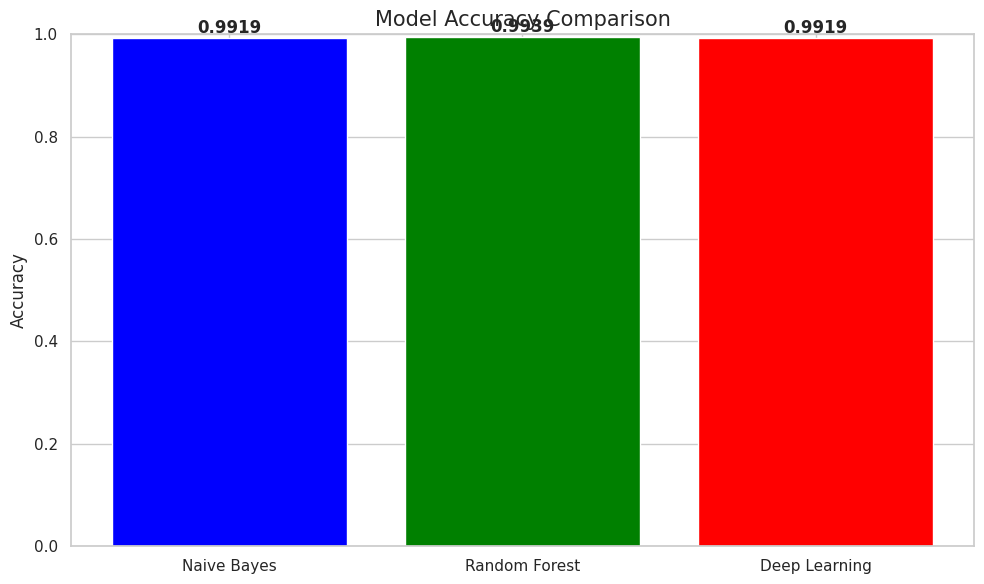

In [53]:
# Compare model performance
models = ['Naive Bayes', 'Random Forest']
accuracies = [accuracy_nb, accuracy_rf]
colors = ['blue', 'green']

# Add deep learning if available
if tensorflow_available and dl_model is not None:
    models.append('Deep Learning')
    accuracies.append(accuracy_dl)
    colors.append('red')

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Save Models
Save all trained models for future use.

In [54]:
# Save models for later use
def save_models(path='models/'):
    '''Save all trained models and components to disk'''
    print(f"Saving models to '{path}'...")
    
    # Save components
    joblib.dump(vectorizer, f'{path}vectorizer.pkl')
    joblib.dump(le, f'{path}label_encoder.pkl')
    
    # Save ML models
    joblib.dump(nb_model, f'{path}naive_bayes_model.pkl')
    joblib.dump(rf_model, f'{path}random_forest_model.pkl')
    
    # Save DL model if available
    if tensorflow_available and dl_model is not None:
        dl_path = f'{path}deep_learning_model'
        dl_model.save(dl_path)
        print(f"Deep learning model saved to {dl_path}")
    
    print("All models saved successfully!")

# Save models
save_models()

Saving models to 'models/'...
INFO:tensorflow:Assets written to: models/deep_learning_model/assets
Deep learning model saved to models/deep_learning_model
All models saved successfully!


## 12. Prediction Functions
Create functions to predict diseases from symptoms using our trained models.

In [55]:
def predict_single_model(symptoms, model_type='rf'):
    '''Predict disease using a single model'''
    # Preprocess and vectorize input
    processed_symptoms = preprocess_text(symptoms)
    X = vectorizer.transform([processed_symptoms])
    
    # Choose model and make prediction
    if model_type == 'nb':
        proba = nb_model.predict_proba(X)[0]
        model_name = "Naive Bayes"
    elif model_type == 'rf':
        proba = rf_model.predict_proba(X)[0]
        model_name = "Random Forest"
    elif model_type == 'dl' and tensorflow_available and dl_model is not None:
        X_dense = X.toarray()
        proba = dl_model.predict(X_dense)[0]
        model_name = "Deep Learning"
    else:
        # Default to Random Forest
        proba = rf_model.predict_proba(X)[0]
        model_name = "Random Forest"
    
    # Get top prediction and probabilities
    pred_idx = np.argmax(proba)
    disease = le.inverse_transform([pred_idx])[0]
    confidence = proba[pred_idx]
    
    # Get top 5 diseases with probabilities
    top_n = min(5, len(proba))
    indices = np.argsort(proba)[::-1][:top_n]
    top_diseases = le.inverse_transform(indices)
    top_probs = proba[indices]
    
    return {
        'disease': disease,
        'confidence': confidence,
        'model': model_name,
        'top_diseases': list(zip(top_diseases, top_probs)),
        'processed_symptoms': processed_symptoms
    }

def predict_ensemble(symptoms):
    '''Predict disease using all available models'''
    print(f"Analyzing symptoms: '{symptoms}'")
    
    # Get predictions from each model
    models_to_use = ['nb', 'rf']
    if tensorflow_available and dl_model is not None:
        models_to_use.append('dl')
    
    results = []
    for model in models_to_use:
        result = predict_single_model(symptoms, model)
        results.append(result)
        print(f"{result['model']} → {result['disease']} ({result['confidence']:.1%})")
    
    # Determine final prediction with weighted voting (higher confidence = more weight)
    disease_votes = {}
    for r in results:
        disease = r['disease']
        confidence = r['confidence']
        if disease not in disease_votes:
            disease_votes[disease] = 0
        disease_votes[disease] += confidence
        
    final_pred = max(disease_votes.items(), key=lambda x: x[1])[0]
    
    # Calculate confidence metrics
    matching_confs = [r['confidence'] for r in results if r['disease'] == final_pred]
    avg_conf = sum(matching_confs) / len(matching_confs) if matching_confs else 0
    confidence_level = "High" if avg_conf >= 0.7 else "Medium" if avg_conf >= 0.4 else "Low"
    
    print(f"\nPrediction: {final_pred} with {avg_conf:.1%} confidence ({confidence_level})")
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Model comparison
    plt.subplot(1, 2, 1)
    model_names = [r['model'] for r in results]
    predicted_diseases = [r['disease'] for r in results]
    confidence_values = [r['confidence'] * 100 for r in results]
    
    # Use different colors for models that agree with ensemble prediction
    colors = ['green' if d == final_pred else 'lightgray' for d in predicted_diseases]
    bars = plt.bar(model_names, confidence_values, color=colors)
    
    # Add disease labels on bars
    for i, (disease, conf) in enumerate(zip(predicted_diseases, confidence_values)):
        plt.text(i, conf/2, disease, ha='center', rotation=90, color='black', fontweight='bold')
        plt.text(i, conf+2, f"{conf:.1f}%", ha='center')
    
    plt.title('Model Predictions')
    plt.ylabel('Confidence (%)')
    plt.ylim(0, 105)
    
    # Plot 2: Top diseases
    plt.subplot(1, 2, 2)
    # Get top diseases from best model or ensemble
    best_model_idx = confidence_values.index(max(confidence_values))
    best_result = results[best_model_idx]
    
    diseases, probs = zip(*best_result['top_diseases'])
    probs = [p * 100 for p in probs]
    
    # Highlight the predicted disease
    bar_colors = ['coral' if d == final_pred else 'lightblue' for d in diseases]
    
    plt.barh(diseases, probs, color=bar_colors)
    plt.title(f'Top Possibilities ({best_result["model"]})')
    plt.xlabel('Probability (%)')
    
    # Add probability labels
    for i, prob in enumerate(probs):
        plt.text(prob + 0.5, i, f'{prob:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'disease': final_pred,
        'confidence': avg_conf,
        'confidence_level': confidence_level,
        'model_predictions': results
    }

## 13. Testing Predictions
Test the prediction system with example cases.


===== EXAMPLE 1: COMMON COLD SYMPTOMS =====
Analyzing symptoms: 'fever headache cough runny nose'
Naive Bayes → Common Cold (21.9%)
Random Forest → GERD (4.6%)
1/1 [==============================] - 0s 11ms/step
Deep Learning → Paralysis (brain hemorrhage) (38.8%)

Prediction: Paralysis (brain hemorrhage) with 38.8% confidence (Low)


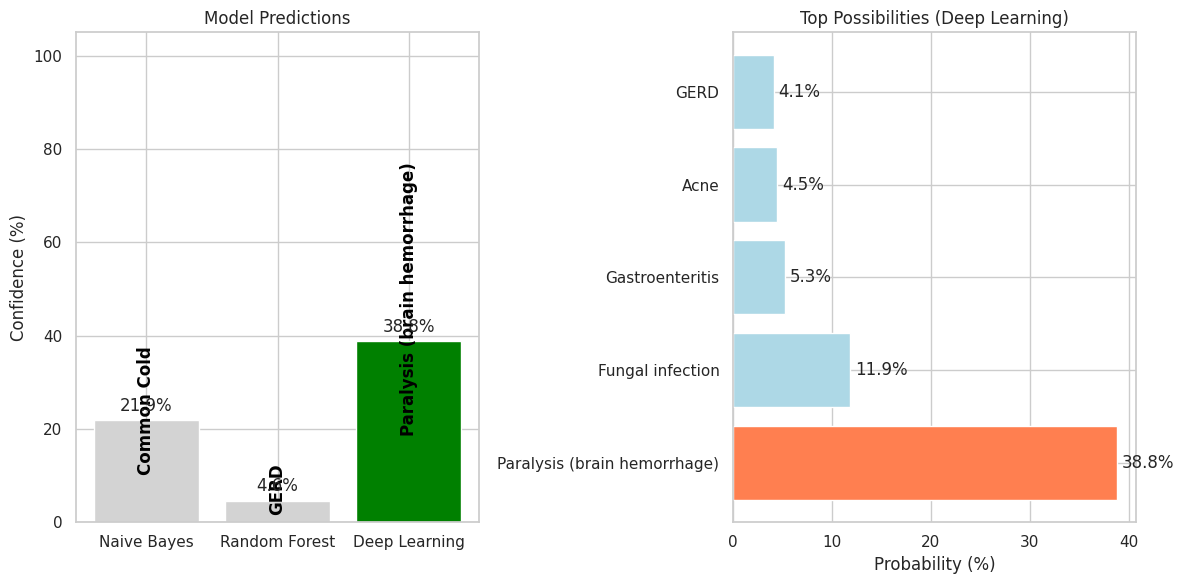

In [59]:
# Example 1: Common Cold
print("\n===== EXAMPLE 1: COMMON COLD SYMPTOMS =====")
cold_symptoms = "fever headache cough runny nose"
result = predict_ensemble(cold_symptoms)


===== EXAMPLE 2: HEART ATTACK SYMPTOMS =====
Analyzing symptoms: 'chest pain shortness of breath pain in arm sweating'
Naive Bayes → Heart attack (30.2%)
Random Forest → Heart attack (4.2%)
1/1 [==============================] - 0s 13ms/step
Deep Learning → Heart attack (81.5%)

Prediction: Heart attack with 38.6% confidence (Low)


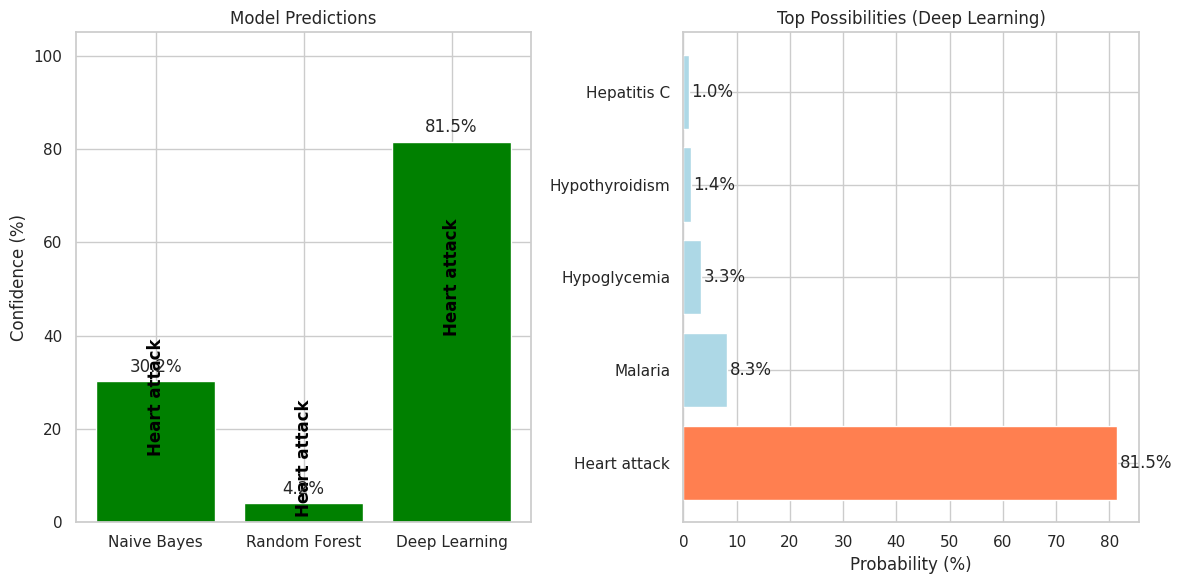

In [60]:
# Example 2: Heart Attack
print("\n===== EXAMPLE 2: HEART ATTACK SYMPTOMS =====")
heart_symptoms = "chest pain shortness of breath pain in arm sweating"
result = predict_ensemble(heart_symptoms)

## 14. Interactive Symptom Analyzer
Create an interactive interface for users to input symptoms and get predictions.

In [61]:
try:
    import ipywidgets as widgets
    from IPython.display import clear_output, display
    
    # Create widgets
    symptom_input = widgets.Text(
        value='', 
        placeholder='Enter symptoms (e.g., "fever headache cough")',
        description='Symptoms:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='90%')
    )
    
    model_dropdown = widgets.Dropdown(
        options=['Ensemble (All Models)', 'Random Forest', 'Naive Bayes'] + 
                (['Deep Learning'] if tensorflow_available and dl_model is not None else []),
        value='Ensemble (All Models)',
        description='Model:',
        style={'description_width': 'initial'}
    )
    
    output_area = widgets.Output()
    
    # Define prediction function
    def on_analyze_click(b):
        with output_area:
            clear_output()
            symptoms = symptom_input.value.strip()
            
            if not symptoms:
                print("Please enter symptoms first.")
                return
            
            # Make prediction based on selected model
            model_choice = model_dropdown.value
            
            if model_choice == 'Ensemble (All Models)':
                predict_ensemble(symptoms)
            elif model_choice == 'Random Forest':
                result = predict_single_model(symptoms, 'rf')
                print(f"Random Forest predicts: {result['disease']} (confidence: {result['confidence']:.2%})")
            elif model_choice == 'Naive Bayes':
                result = predict_single_model(symptoms, 'nb')
                print(f"Naive Bayes predicts: {result['disease']} (confidence: {result['confidence']:.2%})")
            elif model_choice == 'Deep Learning':
                result = predict_single_model(symptoms, 'dl')
                print(f"Deep Learning predicts: {result['disease']} (confidence: {result['confidence']:.2%})")
    
    # Create button
    analyze_button = widgets.Button(
        description='Analyze Symptoms',
        button_style='primary',
        icon='search'
    )
    analyze_button.on_click(on_analyze_click)
    
    # Display interactive interface
    print("\n===== INTERACTIVE SYMPTOM ANALYZER =====")
    print("Enter symptoms and select a prediction model to analyze.")
    display(symptom_input, model_dropdown, analyze_button, output_area)
    
except ImportError:
    print("\n===== SYMPTOM ANALYZER =====")
    print("IPython widgets not available for interactive interface.")
    print("Use predict_ensemble() or predict_single_model() functions directly.")
    print("Example: predict_ensemble('fever headache cough')")


===== INTERACTIVE SYMPTOM ANALYZER =====
Enter symptoms and select a prediction model to analyze.


Text(value='', description='Symptoms:', layout=Layout(width='90%'), placeholder='Enter symptoms (e.g., "fever …

Dropdown(description='Model:', options=('Ensemble (All Models)', 'Random Forest', 'Naive Bayes', 'Deep Learnin…

Button(button_style='primary', description='Analyze Symptoms', icon='search', style=ButtonStyle())

Output()